Reference from [here](https://nbviewer.jupyter.org/github/julienr/ipynb_playground/blob/master/bitcoin/dumbcoin/dumbcoin.ipynb#attacks)

In [1]:
%matplotlib inline

import hashlib
import random
import string
import json
import binascii
import numpy as np
import pandas as pd
import pylab as pl
import logging

## Hash function and mining

Hash function that turn a string into a fixed-length string of 64 hexadecimal characters

In [2]:
def sha256(message):
    return hashlib.sha256(message.encode('ascii')).hexdigest()

In [3]:
#example 

message = 'hello world'
print(sha256(message))

b94d27b9934d3e08a52e52d7da7dabfac484efe37a5380ee9088f7ace2efcde9


Given a string (string), find a nonce that hash(x + nonce) produces a hash starting with a number that has 2 leading numbers

In [4]:
for nonce in range(1000):
    digest = sha256(message + str(nonce))
    if digest.startswith('58'):
        print('found nonce: {}'.format(nonce))
        break
print(sha256(message + str(nonce)))

found nonce: 762
58e0081439d67fa3fc3e94bcce079c4d65b69db5a3a4fdef15aa77d490ae0aa4


The more you increase the number in leading, the harder it to find a nonce. This is called mining difficulty. Bitcoin require for a number to be below a certain value.

Define 2 functions: hash a string and to mine a nonce a given string

In [5]:
def normal_hash(message):
    return sha256(message)

def mine(message, difficulty=1):
    assert difficulty >= 1, "Difficulty of 0 is not possible" #hard debug for any possible buggy inputs with error msg
    i = 0
    prefix = '1' * difficulty
    while True:
        nonce = str(i)
        digest = normal_hash(message + nonce)
        if digest.startswith(prefix):
            return nonce, i
        i += 1

In [6]:
none, num_of_iterations = mine('42', difficulty=1)
print('Took {} iterations'.format(num_of_iterations))

Took 23 iterations


In [7]:
none, num_of_iterations = mine('42', difficulty=3)
print('Took {} iterations'.format(num_of_iterations))

Took 2272 iterations


The higher the difficulty, the more iterations it took. You could lucky and get the first solution to solve the first or second example by chance. Thus, the difficulty controls the average number of tries. Let's plot this difficulty.

## Plotting difficulty

In [8]:
def random_string(length=10):
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(length))
    #random choice from the alphabets and number and join them as string in a list

strings = [random_string() for i in range(50)] #produce a list of 50 random characters

In [9]:
levels = range(1, 5)
#creating a table with columns of difficulty, each columns for each test string
results = pd.DataFrame(index=strings, columns=levels, dtype=np.int)
results.fillna(value=0)

for level in levels:
    for s in strings:
        _, num_of_iterations = mine(s, difficulty=level)
        results[level][s] = num_of_iterations

In [10]:
results.iloc[:5]

,1,2,3,4
TU1L5QCDSE,5,117,2643,4305
6CHO9DKGF1,6,451,1221,88622
I954YZSAXN,8,50,13509,27054
4XN6O6WU3E,5,61,2061,36530
Z7WCFI11VR,8,89,21328,92072


Text(0,0.5,'Iterations')

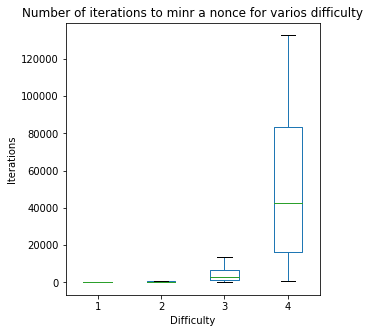

In [11]:
pl.figure(figsize=(10, 5))
ax = pl.subplot(121)#1st num = height, 2nd num= width, 
ax.set_title('Number of iterations to minr a nonce for varios difficulty')
results.plot.box(showfliers=False, ax=ax)
ax.set_xlabel('Difficulty')
ax.set_ylabel('Iterations')

## Building a wallet

1. For building a wallet, you need a key generation that creates a key pair (public and secret key).
2. You also need a function to turn your message into a digital signature with your secret key. 
3. Lastly, you need to have a validation function to check the confirmation of your signature

In [12]:
import Crypto
import Crypto.Random
from Crypto.Hash import SHA
from Crypto.PublicKey import RSA
from Crypto.Signature import PKCS1_v1_5

class Wallet(object):
    
    
    def __init__(self):
        #creates random output of cryptographically bytes, 
        random_gen = Crypto.Random.new().read
        
        #creates private key
        self._private_key = RSA.generate(1024, random_gen) #RSA public-key cryptography(randomised encryption and signature) 
        
        #creates public key
        self._public_key = self._private_key.publickey()
        
        #creates a pen for you sign from your private key
        self._signer = PKCS1_v1_5.new(self._private_key)
    
    @property #embedded python
    def address(self):
        return binascii.hexlify(self._public_key.exportKey(format='DER')).decode('ascii')
        #DER = binary encoding, always unencrypted
        
    def sign(self, message):
        h = SHA.new(message.encode('utf8'))
        return binascii.hexlify(self._signer.sign(h)).decode('ascii')
        #sign with the message, creating a digital signature
    
        #hexlify = return hexadecimal representation of the binary data converted the correspondin 2-digit hex representation
        #returned bytes object is twice as long as the length of data

#validation function
def verify_signature(wallet_address, message, signature):
    pubkey = RSA.importKey(binascii.unhexlify(wallet_address))
    verifier = PKCS1_v1_5.new(pubkey)
    h = SHA.new(message.encode('utf8'))
    return verifier.verify(h, binascii.unhexlify(signature))

w1 = Wallet()
signature = w1.sign('foobar')
assert verify_signature(w1.address, 'foobar', signature)
assert not verify_signature(w1.address, 'rogue message', signature)

## Doing transactions

Transactions is normally consists of:
* Spender, who signs the transactions and the one spending their own money
* Number of inputs, inclusive of other transactions output. The recipient of these should be the spenders wallet. Otherwise, you could spend other people's money
* A number of outputs, each of which specifiy an amount of money and a receiver

Moreover, transactions contain "transaction fee" which is an incentive for miners to put your transaction into the blockchain.

Since all transactions need a parent, we also need a root in our hierachy. Called the genesisTransaction.

In [13]:
class TransactionInput(object):
    
    #an input for transaction, and points to the output of the other transaction

    def __init__(self, transaction, output_index):
        self.transaction = transaction
        self.output_index = output_index
        assert 0 <= self.output_index < len(transaction.outputs)
        #output cannot be less than 0
        
    def to_dict(self):
        d = {
            'transaction' : self.transaction.hash(),
            'output_index' : self.output_index
        }
        return d
    
    @property
    def parent_output(self):
        return self.transaction.outputs[self.output_index]
    
class TransactionOutput(object):
    
    #an output for a transaction which specifies the amount and the receiver's wallet
    
    def __init__(self, receiver_address, amount):
        self.receiver = receiver_address
        self.amount = amount
    
    def to_dict(self):
        d = {
            'receiver_address': self.receiver,
            'amount': self.amount
        }
        return d

def compute_fee(inputs, outputs):
    #compute transaction fee by subtracting the total input by the total output
    
    total_in = sum(i.transaction.outputs[i.output_index].amount for i in inputs)
    total_out = sum(y.amount for y in outputs)
    assert total_out <= total_in, "Invalid transactions with out {} > in {}".format(total_out, total_in)
    #error when input is equal or less than the output
    #you must have a fee with your transaction(input) more than your succesful output transaction
    return total_in - total_out

class Transaction(object):
    def __init__(self, wallet, inputs, outputs):
        #create a transaction spending money from the provided wallet
        
        self.inputs = inputs
        self.outputs = outputs
        self.fee = compute_fee(inputs, outputs)
        self.signature = wallet.sign(json.dumps(self.to_dict(include_signature=False)))
        
    def to_dict(self, include_signature=True):
        d = {
            "inputs": list(map(TransactionInput.to_dict, self.inputs)),
            "outputs": list(map(TransactionOutput.to_dict, self.outputs)),
            "fee": self.fee
        }
        if include_signature:
            d["signature"] = self.signature
        return d
    
    def hash(self):
        return normal_hash(json.dumps(self.to_dict()))
        #light-weight data interchange format
    
class GenesisTransaction(Transaction):
    
    #first transactioin which is a unique transactions with no input and 25 bitcoin output
    
    def __init__(self, receiver_address, amount=25):
        self.inputs = []
        self.outputs = [
            TransactionOutput(receiver_address, amount)
        ]
        self.fee = 0
        self.signature = 'genesis'
    
    def to_dict(self, include_signature=False):
        assert not include_signature, "Cannot include signature of genesis transaction"
        return super().to_dict(include_signature=False)

In [14]:
alice = Wallet()
bob = Wallet()

t1 = GenesisTransaction(alice.address)
t2 = Transaction(alice, 
                 [TransactionInput(t1, 0)], 
                 [TransactionOutput(bob.address, 2.0), TransactionOutput(alice.address, 22.0)])

assert np.abs(t2.fee - 1.0) < 1e5


In [15]:
# ali = Wallet()
# babi = Wallet()
# caca = Wallet()

# #first transaction (ali = 25)
# t1 = GenesisTransaction(ali.address)

# #second transaction(ali=25 ==> ali=10, babi=7, caca=8)
# t2 = Transaction(ali,
#                 [TransactionInput(t1, 0)],
#                 [TransactionOutput(ali.address, 10.0), TransactionOutput(babi.address, 7.0), TransactionOutput(caca.address, 8.0)])

# #third transaction(babi =2=> caca)
# t3 = Transaction(babi,
#                 [TransactionInput(t2, 1)],
#                 [TransactionOutput(caca.address, 2.0)])

# #last transaction(cc =2= > ali, =1=> cc)
# t4 = Transaction(caca,
#                 [TransactionInput(t2, 2), TransactionInput(t3, 0)],
#                 [TransactionOutput(ali.address, 2.0), TransactionOutput(caca.address, 1.0)])

# trans = [t1, t2, t3, t4]

In [16]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

# This gives 25 coins to Alice
t1 = GenesisTransaction(alice.address)

# Of those 25, Alice will spend
# Alice -- 5 --> Bob
#       -- 15 --> Alice
#       -- 5 --> Walter
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)

# Walter -- 5 --> Bob
t3 = Transaction(
    bob,
    [TransactionInput(t2, 2)],
    [TransactionOutput(walter.address, 5.0)])

# Bob -- 8 --> Walter
#     -- 1 --> Bob
#        1 fee
t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

transactions = [t1, t2, t3, t4]

In [17]:
def compute_balance(wallet_address, transactions):
    
    balance = 0
    for t in transactions:
        for trin in t.inputs:
            if trin.parent_output.receiver == wallet_address:
                balance -= trin.parent_output.amount
        for trout in t.outputs:
            if trout.receiver == wallet_address:
                balance += trout.amount
    return balance

print('Ali has {} dummycoin'.format(compute_balance(alice.address, transactions)))
print('Babi has {} dummycoin'.format(compute_balance(bob.address, transactions)))
print('Caca has {} dummycoin'.format(compute_balance(walter.address, transactions)))

Ali has 15.0 dummycoin
Babi has 1.0 dummycoin
Caca has 8.0 dummycoin


In [18]:
assert 2 + 2 == 5, "Houston we've got a problem"

AssertionError: Houston we've got a problem

In [59]:
def verify_transaction(transaction):
    """
    Verify that the transaction is valid.
    We need to verify two things :
    - That all of the inputs of the transaction belong to the same wallet
    - That the transaction is signed by the owner of said wallet
    """
    tx_message = json.dumps(transaction.to_dict(include_signature=False))
    if isinstance(transaction, GenesisTransaction):
        # TODO: We should probably be more careful about validating genesis transactions
        return True
    
    # Verify input transactions
    for tx in transaction.inputs:
        if not verify_transaction(tx.transaction):
            logging.error("Invalid parent transaction")
            return False
    
    # Verify a single wallet owns all the inputs
    first_input_address = transaction.inputs[0].parent_output.receiver
    for txin in transaction.inputs[1:]:
        if txin.parent_output.receiver != first_input_address:
            logging.error(
                "Transaction inputs belong to multiple wallets (%s and %s)" %
                (txin.parent_output.receiver, first_input_address)
            )
            return False
    
    if not verify_signature(first_input_address, tx_message, transaction.signature):
        logging.error("Invalid transaction signature, trying to spend someone else's money ?")
        return False
    
    # Call compute_fee here to trigger an assert if output sum is great than input sum. Without this,
    # a miner could put such an invalid transaction.
    compute_fee(transaction.inputs, transaction.outputs)
    
    return True


t1 = GenesisTransaction(alice.address)
# This is an invalid transaction because bob is trying to spend alice's money
# (alice was the recipient of the input - t1)
t2 = Transaction(
    bob,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)
# This is valid, alice is spending her own money
t3 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)

transactions = [t1, t2, t3]

In [60]:
# def verify_transaction(transaction):
    
#     tx_message = json.dumps(transaction.to_dict(include_signature=False))
    
#     if isinstance(transaction, GenesisTransaction):
#         return True

#     for tx in transaction.inputs:
#         if not verify_transaction(tx.transaction):
#             logging.error('Invalid parent transaction')
#             return False
    
#     first_input_address = transaction.inputs[0].parent_output.receiver
#     for txin in transaction.inputs[1:]:
#         if txin.parent_output.receiver != first_input_address:
#             logging.error(
#                 "Transaction inputs belong to multiple wallets {} {}".format(txin.parent_output.receiver, first_input_address)
#             )
#             return False
    
#     if not verify_signature(first_input_address, tx_message, transaction.signature):
#         logging.error("Invalid transaction signature, trying to spend someone else's money?")
#         return False
    
#     compute_fee(transaction.inputs, transaction.outputs)
    
#     return True

# t1 = GenesisTransaction(alice.address)

# t2 = Transaction(bob, [TransactionInput(t1, 0)], [TransactionOutput(walter.address, 10.0)])

# t3 = Transaction(
#     alice,
#     [TransactionInput(t1, 0)],
#     [TransactionOutput(walter.address, 10.0)]
# )

In [61]:
assert verify_transaction(t1)

In [62]:
assert not verify_transaction(t2)

ERROR:root:Invalid transaction signature, trying to spend someone else's money ?


In [63]:
assert verify_signature(t3)

TypeError: verify_signature() missing 2 required positional arguments: 'message' and 'signature'

In [64]:
print(compute_balance(alice.address, transactions))

-25


In [65]:
?verify_signature(t3)

In [66]:
print(t3.outputs
     )

## Putting transactions in blocks

We have:

* a way to define a wallet (as a private/public key pair)
* create transactions between wallets
* verify transactions (checking signature matches)

Now we need: 

* Verifying the transactions in the block
* Finding a nonce such that block hash starts with a number of 0

First transaction is a genesis transaction that gives 25 coins to whatever the miner chose. Miner can add transactions to redirect the fees from transactions in the block to whatever address it chooses.

In [67]:
BLOCK_INCENTIVE = 25
DIFFICULTY = 2

def compute_total_fee(transactions):
    #Return the total fee for the set of transactions
    return sum(t.fee for t in transactions)

class Block(object):
    def __init__(self, transactions, ancestor, miner_address, skip_verif=False):
        """
        Args:
            transactions: the list of transactions to include in the block
            ancestor: the previous block
            miner_address: the address of the miner's wallet. this is where the incentive
            and the transactions fees will be deposited
        """
        reward = compute_total_fee(transactions) + BLOCK_INCENTIVE
        self.transactions = [GenesisTransaction(miner_address, amount=reward)] + transactions
        self.ancestor = ancestor
        
        if not skip_verif:
            assert all(map(verify_transaction, transactions))
            #check all the the transactions are true
            
        json_block = json.dumps(self.to_dict(include_hash=False))
        self.nonce, _ = mine(json_block, DIFFICULTY)
        self.hash = normal_hash(json_block + self.nonce)
        
    def fee(self):
        return compute_total_fee(self.transactions)
    
    def to_dict(self, include_hash=True):
        d = {
            "transactions" : list(map(Transaction.to_dict, self.transactions)),
            "previous_block" : self.ancestor.hash
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d
    
class GenesisBlock(Block):
    
    def __init__(self, miner_address):
        super(GenesisBlock, self).__init__(transactions=[], ancestor=None, miner_address = miner_address)
        
    def to_dict(self, include_hash=True):
        d = {
            "transactions": [],
            "genesis_block": True,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d

In [77]:
 def verify_block(block, genesis_block, used_outputs=None):
        '''
        verifies that a block is valid:
        - where it starts with the required amount of ones
        - same transaction isnt used twice
        - transactions are valid
        - first transaction in the block is a genesis transaction with block incentive and total fees
        
        Args:
            block: the block to validate
            genesis_block: the genesis block (this needs to be shared by everybody)
            used_outputs: list of outputs used in transactions for all blocks above this one
        '''
        if used_outputs is None:
            used_outputs = set()
            #unordered collection with no duplicate elements
            
        prefix = '1' * DIFFICULTY
        if not block.hash.startswith(prefix):
            logging.error("Block hash {} doesn't start with prefix {}".format(block.hash, prefix))
            return False
        if not all(map(verify_transaction, block.transactions)):
            return False
        
        #verify that transactions in this block don't use alredy spent outputs
        
        for transactions in block.transactions:
            for i in transactions.inputs:
                if i.parent_output in used_outputs:
                    logging.error("Transaction uses an already spent output : {}".format(json.dumps(i.parent_output.to_dict())))
                    return False
                used_outputs.add(i.parent_output)
                
        if not (block.hash == genesis_block.hash):
            if not verify_block(block.ancestor, genesis_block, used_outputs):
                logging.error("Failes to validate ancestor block")
                return False
            
        tx0 = block.transactions[0]
        if not isinstance(tx0, GenesisTransaction):
            logging.error("Transaction 0 is not a GenesisTransaction")
            return False
        if not len(tx0.outputs) == 1:
            logging.error("Transaction 0 doesn't have exactly 1 output")
            return False
        reward = compute_total_fee(block.transactions[1:]) + BLOCK_INCENTIVE
        if not tx0.outputs[0].amount == reward:
            logging.error("Invalid amount in transaction 0 : {} expected {}".format(tx0.outputs[0].amount, reward))
            
        for i, tx in enumerate(block.transactions):
            if i == 0:
                if not isinstance(tx, GenesisTransaction):
                    logging.error("Non-genesis transaction at index 0")
                    return False
            elif isinstance(tx, GenesisTransaction):
                logging.error("GenesisTransaction (hash={}) at index {} is not equal 0".format(tx.hash(), i))
                return False
        return True

In [78]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)
print("genesis_block : " + genesis_block.hash + " with fee=" + str(genesis_block.fee()))

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
print("block1        : " + block1.hash + " with fee=" + str(block1.fee()))

block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)
print("block2        : " + block2.hash + " with fee=" + str(block2.fee()))

genesis_block : 1162dce8ffec3acf13ce61109f121922eee8cceeea4784aa9d90dc6ec0e0fa92 with fee=0
block1        : 11246ee6a6d7a1001d4573fbd4761d5f6b43f71e92f6f614ca17e72f80d0d3c8 with fee=0.0
block2        : 118156361c44b907636a2b84d2b7ab7528f2a73eb659a1741e9d79185fda1ceb with fee=1.0


In [79]:
verify_block(block1, genesis_block)

True

In [83]:
def collect_transactions(block, genesis_block):
    # recursively collect transactions in 'block' and all of its ancestors
    transactions = [] + block.transactions
    if block.hash != genesis_block.hash:
        transactions += collect_transactions(block.ancestor, genesis_block)
    return transactions

transactions = collect_transactions(block2, genesis_block)
print("alice has {} dumbcoins".format(compute_balance(alice.address, transactions)))

alice has 15.0 dumbcoins
